In [33]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import logging

In [2]:
from backtesting import perform_backtest

In [27]:
source_folder = 'files'

# Reading data

## VFINX

In [3]:
with open(f'{source_folder}/VFINX.json', 'r') as file:
    _vfinx = json.load(file)

vfinx = pd.DataFrame.from_dict(_vfinx).copy()
vfinx.index = pd.Series(pd.to_numeric(vfinx.index)).apply(lambda _date: datetime.fromtimestamp(_date * 1e-3))
vfinx.sort_index(ascending=True, inplace=True)

vfinx.index = vfinx.index.tz_localize(None).floor(freq='D')

In [4]:
vfinx.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,VIX_Close
count,8833.000000,8833.000000,8833.000000,8833.000000,8833.0,8833.000000,8833.0,8833.000000
mean,91.410905,91.410905,91.410905,91.410905,0.0,0.008916,0.0,19.925365
std,74.364430,74.364430,74.364430,74.364430,0.0,0.081741,0.0,8.501164
min,9.693998,9.693998,9.693998,9.693998,0.0,0.000000,0.0,9.140000
25%,26.499744,26.499744,26.499744,26.499744,0.0,0.000000,0.0,14.090000
50%,77.715508,77.715508,77.715508,77.715508,0.0,0.000000,0.0,18.130000
75%,107.777855,107.777855,107.777855,107.777855,0.0,0.000000,0.0,23.250000
max,355.809998,355.809998,355.809998,355.809998,0.0,1.390000,0.0,150.190000


In [5]:
vfinx['Volume'].value_counts()

0    8833
Name: Volume, dtype: int64

In [6]:
vfinx['Dividends'].value_counts()

0.000    8692
0.180      15
0.220      12
0.350       5
0.300       5
         ... 
0.520       1
0.480       1
0.490       1
0.530       1
1.311       1
Name: Dividends, Length: 91, dtype: int64

In [7]:
vfinx['Stock Splits'].value_counts()

0    8833
Name: Stock Splits, dtype: int64

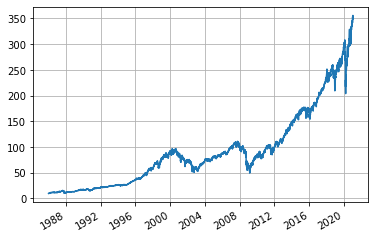

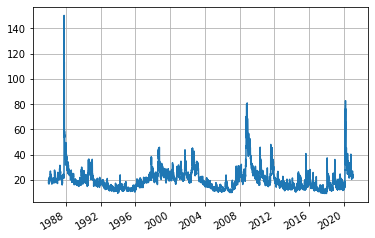

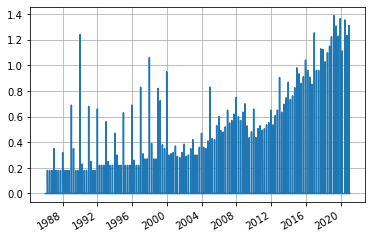

In [8]:
_cols = ['Close']
vfinx['Close'].plot()

plt.grid()
plt.show()

vfinx['VIX_Close'].plot()
plt.grid()
plt.show()

vfinx['Dividends'].plot()
plt.grid()
plt.show()

## 10Y US Notes

In [9]:
ust = pd.read_csv('files/ust_10y_yields_hist.csv')
ust['Date'] = pd.to_datetime(ust['Date'])
ust.set_index('Date', inplace=True)
ust.sort_index(ascending=True, inplace=True)

In [11]:
ust['Close'].describe()

count    9061.000000
mean        4.727160
std         2.321428
min         0.499000
25%         2.624000
50%         4.564000
75%         6.537000
max        10.230000
Name: Close, dtype: float64

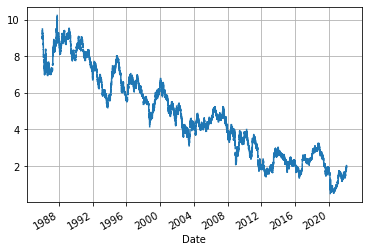

In [12]:
ust['Close'].plot()

plt.grid()
plt.show()

# Strategy

In [105]:
portfolio = pd.read_excel(f'{source_folder}/test_portfolio.xlsx', index_col=[0, 1])
portfolio['rebalance'].replace(np.nan, 0, inplace=True)

secs = portfolio.index.get_level_values('sec').unique().values

In [121]:
portfolio = portfolio.unstack(level='sec').copy()

In [71]:
def do_rebalance(df, sec):
    df = df.copy()
    
    amt_chg = df.iloc[1]['rebalance'][sec]  # df.iloc[1]['#'][sec] - df.iloc[0]['#'][sec]
    df.iloc[1]['#'] = df.iloc[0]['#'] + amt_cgh
    df.iloc[1]['value'] = df.iloc[1]['#'] * df.iloc[1]['price']

In [140]:
portfolio.xs('VFINX', axis='columns', level='sec')

,price,weight,#,value,rebalance,rebalance price,total
date,,,,,,,
2020-02-01,10,0.5,5,50,0.0,NaN,100.0
2020-02-02,11,0.5,5,55,0.0,NaN,105.0
2020-02-03,12,0.4,4,48,-1.0,11.0,109.0


In [143]:
portfolio.iloc[-1]['#']['VFINX']

4.0

In [107]:
portfolio['total']

date        sec  
2020-02-01  VFINX    100.0
            cash       NaN
2020-02-02  VFINX    105.0
            cash       NaN
2020-02-03  VFINX    109.0
            cash       NaN
Name: total, dtype: float64

In [122]:
portfolio

price      weight          #      value      rebalance        \
sec        VFINX cash  VFINX cash VFINX cash VFINX cash     VFINX  cash   
date                                                                      
2020-02-01    10    1    0.5  0.5     5   50    50   50       0.0   0.0   
2020-02-02    11    1    0.5  0.5     5   50    55   50       0.0   0.0   
2020-02-03    12    1    0.4  0.6     4   61    48   61      -1.0  11.0   

           rebalance price       total       
sec                  VFINX cash  VFINX cash  
date                                         
2020-02-01             NaN  NaN  100.0  NaN  
2020-02-02             NaN  NaN  105.0  NaN  
2020-02-03            11.0  1.0  109.0  NaN

In [128]:
portfolio.iloc[1]['price'] - portfolio.iloc[0]['price']

sec
VFINX    1.0
cash     0.0
dtype: float64

In [137]:
portfolio.rolling(2, min_periods=2, axis='index').apply(lambda _df: _df.iloc[1])

price      weight          #       value       rebalance        \
sec        VFINX cash  VFINX cash VFINX  cash VFINX  cash     VFINX  cash   
date                                                                        
2020-02-01   NaN  NaN    NaN  NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2020-02-02  11.0  1.0    0.5  0.5   5.0  50.0  55.0  50.0       0.0   0.0   
2020-02-03  12.0  1.0    0.4  0.6   4.0  61.0  48.0  61.0      -1.0  11.0   

           rebalance price       total       
sec                  VFINX cash  VFINX cash  
date                                         
2020-02-01             NaN  NaN    NaN  NaN  
2020-02-02             NaN  NaN  105.0  NaN  
2020-02-03             NaN  NaN  109.0  NaN

In [123]:
portfolio.rolling(2, on=portfolio.index.get_level_values('date')).apply(lambda _df: _df)

DataError: No numeric types to aggregate

In [114]:
portfolio.groupby('sec').apply(
    lambda _df: _df['price'].rolling(2, min_periods=2, axis='index').apply(
        lambda _df: _df['weight'].mean()
    )
)

KeyError: 'weight'

In [102]:
portfolio.rolling(2, min_periods=2, axis='index').\
    apply(lambda _df: _df)

DataError: No numeric types to aggregate

In [89]:
portfolio

price      weight          #      value      rebalance        \
sec        VFINX cash  VFINX cash VFINX cash VFINX cash     VFINX  cash   
date                                                                      
2020-02-01    10    1    0.5  0.5     5   50    50   50       0.0   0.0   
2020-02-02    11    1    0.5  0.5     5   50    55   50       0.0   0.0   
2020-02-03    12    1    0.4  0.6     4   61    48   61      -1.0  11.0   

           rebalance price       total       
sec                  VFINX cash  VFINX cash  
date                                         
2020-02-01             NaN  NaN  100.0  NaN  
2020-02-02             NaN  NaN  105.0  NaN  
2020-02-03            11.0  1.0  109.0  NaN

# Backtesting

In [13]:
# logging.basicConfig(level=logging.DEBUG)

In [14]:
annualization_factor = 360

portf_res = perform_backtest(vfinx['Close'], ust['Close'] / 100, risk_free_annualized=True,
                             annualization_factor=annualization_factor).copy()

In [15]:
portf_res.describe()

,value,daily return,daily return ann,total return,risk free rate,risk free rate daily,excess return,excess return daily,daily PnL,total PnL
count,8833.000000,8832.000000,8.832000e+03,8832.000000,8790.000000,8790.000000,8.789000e+03,8789.000000,8832.000000,8832.000000
mean,91.410905,0.000473,1.618463e+13,8.170011,0.048241,0.000130,1.626382e+13,0.000338,0.039037,81.450659
std,74.364430,0.011688,1.408506e+15,7.459134,0.022859,0.000060,1.411947e+15,0.011706,1.376222,74.363590
min,9.693998,-0.204649,-1.000000e+00,-0.027631,0.004990,0.000014,-1.102300e+00,-0.204918,-29.584320,-0.275469
25%,26.499744,-0.004183,-7.788449e-01,1.658446,0.027502,0.000075,-8.303978e-01,-0.004329,-0.243201,16.533826
50%,77.715508,0.000691,2.821215e-01,6.796972,0.046400,0.000126,2.292074e-01,0.000553,0.029929,67.762188
75%,107.777855,0.005736,6.838076e+00,9.812802,0.065890,0.000177,6.788792e+00,0.005604,0.370338,97.828411
max,355.809998,0.115723,1.319313e+17,34.689971,0.102300,0.000271,1.319313e+17,0.115618,21.052658,345.840530


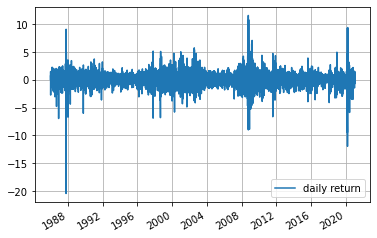

In [16]:
_cols = ['daily return']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

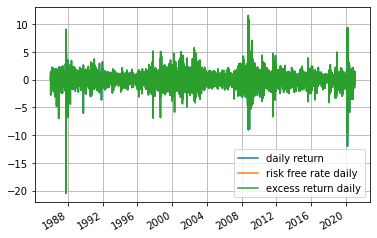

In [17]:
_cols = ['daily return', 'risk free rate daily', 'excess return daily']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

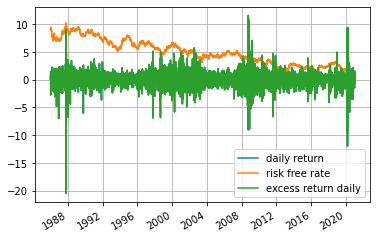

In [18]:
_cols = ['daily return', 'risk free rate', 'excess return daily']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

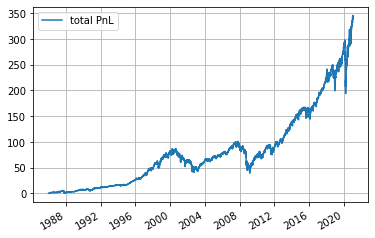

In [19]:
_cols = ['total PnL']
_data = portf_res[_cols]
_data.plot()

plt.grid()
plt.show()

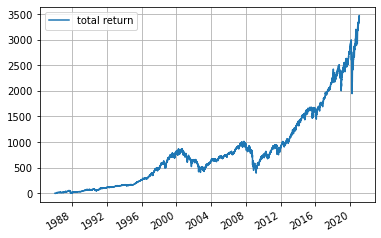

In [20]:
_cols = ['total return']
_data = portf_res[_cols] * 100
_data.plot()

plt.grid()
plt.show()

## Buy and hodl CAGR

In [26]:
(portf_res['total return'].iloc[-1] + 1) ** (1 / 35) - 1

0.10744225828819376

## Sharpe

In [21]:
portf_res['excess return'].mean() / portf_res['excess return'].std()

0.011518717683548022

In [22]:
portf_res['excess return daily'].mean() / portf_res['excess return daily'].std()

0.02888785870970048